In [0]:
import torch
import matplotlib.pyplot as plt
import numpy as np
import torch.nn.functional as F
from torch import nn
from torchvision import datasets, transforms

In [0]:
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpt")

In [11]:
transform_train = transforms.Compose([transforms.Resize((64,64)),
                                      transforms.RandomHorizontalFlip(),
                                      transforms.RandomRotation(10),
                                      transforms.RandomAffine(0, shear=10, scale=(0.8,1.2)),
                                      transforms.ColorJitter(brightness=0.2, contrast=0.2, saturation=0.2),
                                      transforms.ToTensor(),
                                      transforms.Normalize((0.5, 0.5, 0.5),(0.5, 0.5, 0.5)),
                                     ])

transform = transforms.Compose([transforms.Resize((64,64)),
                                transforms.ToTensor(),
                                transforms.Normalize((0.5, 0.5, 0.5),(0.5, 0.5, 0.5)),
                               ])

train_data_with_teacher_labels = datasets.CIFAR10(root='./data', train=True, download=True, transform=transform_train)
test_data_with_teacher_labels = datasets.CIFAR10(root='./data', train=False, download=True, transform=transform)

train_data_loader = torch.utils.data.DataLoader(train_data_with_teacher_labels, batch_size=32, shuffle=True)
test_data_loader = torch.utils.data.DataLoader(test_data_with_teacher_labels, batch_size = 32, shuffle=False)

Files already downloaded and verified
Files already downloaded and verified


In [0]:
def im_convert(tensor):
  image = tensor.clone().detach().numpy()
  image = image.transpose(1,2,0)
  image = image * np.array((0.5,0.5,0.5)) + np.array((0.5,0.5,0.5))
  image = image.clip(0,1)
  return image

NameError: ignored

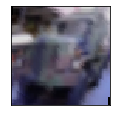

In [13]:
dataiter = iter(training_loader)
images, labels = dataiter.next()
fig = plt.figure(figsize=(25, 4))

for idx in np.arange(20):
  ax = fig.add_subplot(2, 10, idx+1, xticks=[], yticks=[])
  plt.imshow(im_convert(images[idx]))
  ax.set_title(classes[labels[idx].item()])

In [0]:
# 「3*3 convolution層」
def conv3x3(in_channels, out_channels, stride=1):
    return nn.Conv2d(in_channels, out_channels, kernel_size=3,
                    stride=stride, padding=1, bias=False)
    
# 入力サイズ：（H、W）、フィルターサイズ：（FH、FW）、出力サイズ：（OH、OW）、パディング：P、ストライド：S
# OH = (H + 2P - FH) / S + 1
# OW = (W + 2P - FW) / S + 1

# Residual block
class ResidualBlock(nn.Module):
    def __init__(self, in_channels, out_channels, stride=1, downsample=None):
        super(ResidualBlock, self).__init__()
        self.conv1 = conv3x3(in_channels, out_channels, stride)
        self.bn1 = nn.BatchNorm2d(out_channels)
        self.relu = nn.ReLU(inplace=True)
        self.conv2 = conv3x3(out_channels, out_channels)
        self.bn2 = nn.BatchNorm2d(out_channels)
        self.downsample = downsample

    def forward(self, x):
        residual = x
        out = self.conv1(x) #　「3*3 convolution層」
        out = self.bn1(out) #　「BatchNorm層」　　　　：アクティベーションの分布を調整し、過学習を抑える
        out = self.relu(out)  #　「ReLU層」
        out = self.conv2(out) #　「3*3 convolution層」
        out = self.bn2(out) #　「BatchNorm層」
        if self.downsample: #　スキップ構造、ショートカット、バイパス
          residual = self.downsample(x)   #　「ResNet」の「layer１」、「layer2」の場合、入る。　　downsample：「3*3 convolution層」　から「BatchNorm層」
        out += residual
        out = self.relu(out)    #　「ReLU層」
        return out

# ResNet
class ResNet(nn.Module):
    def __init__(self, block, layers, num_classes=10):
        super(ResNet, self).__init__()
        self.in_channels = 64        # MNISTだと１６だったが、駄目で、６４にすると動いた（CIFER-10は「３２×３２」だから？）
        self.conv = conv3x3(3, 64)    # RGBなので入力チャネル数は3
        self.bn = nn.BatchNorm2d(64)
        self.relu = nn.ReLU(inplace=True)
        self.layer1 = self.make_layer(block, 64, layers[0])
        self.layer2 = self.make_layer(block, 128, layers[0], 2)
        self.layer3 = self.make_layer(block, 256, layers[1], 2)
        self.avg_pool = nn.AvgPool2d(8)   #「Avarageプーリング層」 
        self.fc = nn.Linear(1024, num_classes)

    def make_layer(self, block, out_channels, blocks, stride=1):     
        downsample = None
        if (stride != 1) or (self.in_channels != out_channels):     #「layer２」、「layer３」の場合入る
            downsample = nn.Sequential(
                conv3x3(self.in_channels, out_channels, stride=stride), #「3*3 convolution層」
                nn.BatchNorm2d(out_channels)) #「BatchNorm層」
        layers = []
        layers.append(block(self.in_channels, out_channels, stride, downsample))
        self.in_channels = out_channels
        for i in range(1, blocks):   # [1, 2]
            layers.append(block(out_channels, out_channels))
        return nn.Sequential(*layers)

    def forward(self, x):
        out = self.conv(x) #「3*3 convolution層」            224*224
        out = self.bn(out)  #「BatchNorm層」
        out = self.layer1(out)    #「make_layer」から「Residual block」
        out = self.layer2(out)    #「make_layer」から「Residual block」
        out = self.layer3(out)    #「make_layer」から「Residual block」
        out = self.avg_pool(out)   #「Avarageプーリング層」 112*112
        out = out.view(out.size(0), -1)
        out = self.fc(out)
        return out

In [0]:
# Create ResNet
net_args = {
    "block": ResidualBlock,
    "layers": [2, 2, 2, 2] 
#    "layers": [3, 4, 6, 3]  #resnet18
}
model = ResNet(**net_args)

# Cross Entropy Loss 
error = nn.CrossEntropyLoss()
#withEdit付きでやるといい。

# Adam Optimizer
optimizer = torch.optim.Adam(model.parameters(), lr=0.05)

In [16]:
model.to(device)

ResNet(
  (conv): Conv2d(3, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
  (bn): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu): ReLU(inplace=True)
  (layer1): Sequential(
    (0): ResidualBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    )
    (1): ResidualBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=

In [17]:
#学習回数
MAX_EPOCH = 10     #20

for epoch in range(MAX_EPOCH):

  total_loss = 0.0

  for i, data in enumerate(train_data_loader, 0): #　12500回ループ

    train_data, teacher_labels = data
#    train_data = train_data.cuda()
#    teacher_labels = teacher_labels.cuda()
    train_data, teacher_labels = train_data.cuda(), teacher_labels.cuda()
    #計算された勾配を削除
    optimizer.zero_grad()
    #予測計算
    outputs = model(train_data)
    #微分計算
    loss = error(outputs, teacher_labels)
    loss.backward()
    #勾配を更新
    optimizer.step()
    #誤差を累計
    total_loss += loss.item()

    #2000ミニバッチずつ進捗表示
    if i % 100 == 99:
      print('学習進捗：[%d, %5d] loss: %.3f' % (epoch + 1, i + 1, total_loss / 100))
      total_loss = 0.0
  
  print('学習終了')

学習進捗：[1,   100] loss: 3.969
学習進捗：[1,   200] loss: 2.094
学習進捗：[1,   300] loss: 2.056
学習進捗：[1,   400] loss: 1.999
学習進捗：[1,   500] loss: 1.889
学習進捗：[1,   600] loss: 1.907
学習進捗：[1,   700] loss: 1.826
学習進捗：[1,   800] loss: 1.856
学習進捗：[1,   900] loss: 1.843
学習進捗：[1,  1000] loss: 1.824
学習進捗：[1,  1100] loss: 1.808
学習進捗：[1,  1200] loss: 1.783
学習進捗：[1,  1300] loss: 1.784
学習進捗：[1,  1400] loss: 1.736
学習進捗：[1,  1500] loss: 1.717
学習終了
学習進捗：[2,   100] loss: 1.674
学習進捗：[2,   200] loss: 1.729
学習進捗：[2,   300] loss: 1.676
学習進捗：[2,   400] loss: 1.625
学習進捗：[2,   500] loss: 1.623
学習進捗：[2,   600] loss: 1.621
学習進捗：[2,   700] loss: 1.634
学習進捗：[2,   800] loss: 1.580
学習進捗：[2,   900] loss: 1.562
学習進捗：[2,  1000] loss: 1.587
学習進捗：[2,  1100] loss: 1.532
学習進捗：[2,  1200] loss: 1.477
学習進捗：[2,  1300] loss: 1.439
学習進捗：[2,  1400] loss: 1.466
学習進捗：[2,  1500] loss: 1.468
学習終了
学習進捗：[3,   100] loss: 1.439
学習進捗：[3,   200] loss: 1.452
学習進捗：[3,   300] loss: 1.437
学習進捗：[3,   400] loss: 1.371
学習進捗：[3,   500] loss: 1.393
学習進捗：[3,  

In [18]:
#検証
count_when_correct = 0
total = 0
with torch.no_grad():
  for data in test_data_loader: #2500回ループ
    test_data, teacher_labels = data
    test_data, teacher_labels = test_data.cuda(), teacher_labels.cuda()
    results = model(test_data)
    _, predicted = torch.max(results.data, 1)
    total += teacher_labels.size(0)
    count_when_correct += (predicted == teacher_labels).sum().item()

print('10000 検証画像に対しての正解率： %d %%' % (100 * count_when_correct / total))

10000 検証画像に対しての正解率： 65 %
